### Miniproject Henrik Ågotnes

In [1]:
import numpy as np
import time

import code
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
from skimage import io, transform

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
print('modules imported')


_path = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/annotations/xmls/Norway_002967.xml'
xml_paths = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/annotations/xmls'
image_path = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/images'






class RoadDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, train=True,transform=None, country='Norway'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/' + country +'/'
        self.path_train_or_test = 'train' if train else 'test'
        self.country = country
        self.n_samples = 8160 if train else 2040
        self.image_dir = os.path.join(self.root_dir,self.path_train_or_test, 'images')
        self.annotation_dir = os.path.join(self.root_dir,self.path_train_or_test, 'annotations', 'xmls')
        

        #self.root_dir = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/'
        #self.image_dir = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/images/'
        #self.annotation_dir = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/annotations/xmls/'
        self.transform = transform

        self.img_shape = (3, 2044, 3650)
        self.num_classes = 4

        self.transform = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float)])
        self.crack_name_to_label = {
            'D00': 1,
            'D10': 2,
            'D20': 3,
            'D40': 4,
        }
        self.num_classes = 4
        

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.path_train_or_test == 'test':
            idx = idx + 8161

        img_name = os.path.join(self.image_dir, self.country + '_'
                                 + f'{idx:06d}' + '.jpg')
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)
        if self.path_train_or_test == 'test':
            return image, {'image_id': idx}

        annotation_name = os.path.join(self.annotation_dir, self.country +'_' + f'{idx:06d}' + '.xml')
        root = ET.parse(annotation_name).getroot()
        labels, boxes = ([], [])
        
        for _object in root.findall("object"):
            name = _object.find('name').text
            if name in self.crack_name_to_label:
                labels.append(self.crack_name_to_label[name])
            #labels.append(self.crack_name_to_label[_object.find('name').text])
            boxes.append([float(i.text) for i in _object.find('bndbox')])
            if _object.find('name').text not in self.crack_name_to_label:
                print('[WARNING]Found where object name:', _object.find('name').text)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        boxes = torch.tensor(boxes, dtype=torch.float32)

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        if boxes.shape[0] > 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
        else:
            area = torch.tensor([])

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx]), 'iscrowd':iscrowd, 'area':area}



        return image, target
    
    def get_pil(self, idx):
        img_name = os.path.join(self.image_dir,
                                'Norway_' + f'{idx:06d}' + '.jpg')
        return Image.open(img_name).convert("RGB") # transforms.functional.pil_to_tensor(




/cluster/home/henrikya/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


modules imported


In [35]:
road_dataset = RoadDataset(train=True)
x, y = road_dataset[0]

### Transforms

In [2]:
import albumentations as A
import cv2


transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='pascal_voc'))
transformed = transform(image=images[0], bboxes=targets[0]['boxes'], category_ids=targets[0]['boxes'])

NameError: name 'images' is not defined

### Dataloaders setup

In [2]:
def collate_fn(batch):
    return tuple(zip(*batch))
road_dataset = RoadDataset(train=True)

train_size = int(len(road_dataset) * 0.75)
val_size = len(road_dataset) - train_size
train_size, val_size
train_data, val_data = torch.utils.data.random_split(road_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
test_data = RoadDataset(train=False)

train_data_loader = DataLoader(train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=collate_fn)
val_data_loader = DataLoader(val_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=collate_fn)
test_data_loader = DataLoader(test_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=collate_fn)

In [3]:
images, targets = next(iter(train_data_loader))

In [4]:
images[0].shape

torch.Size([3, 2041, 3643])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


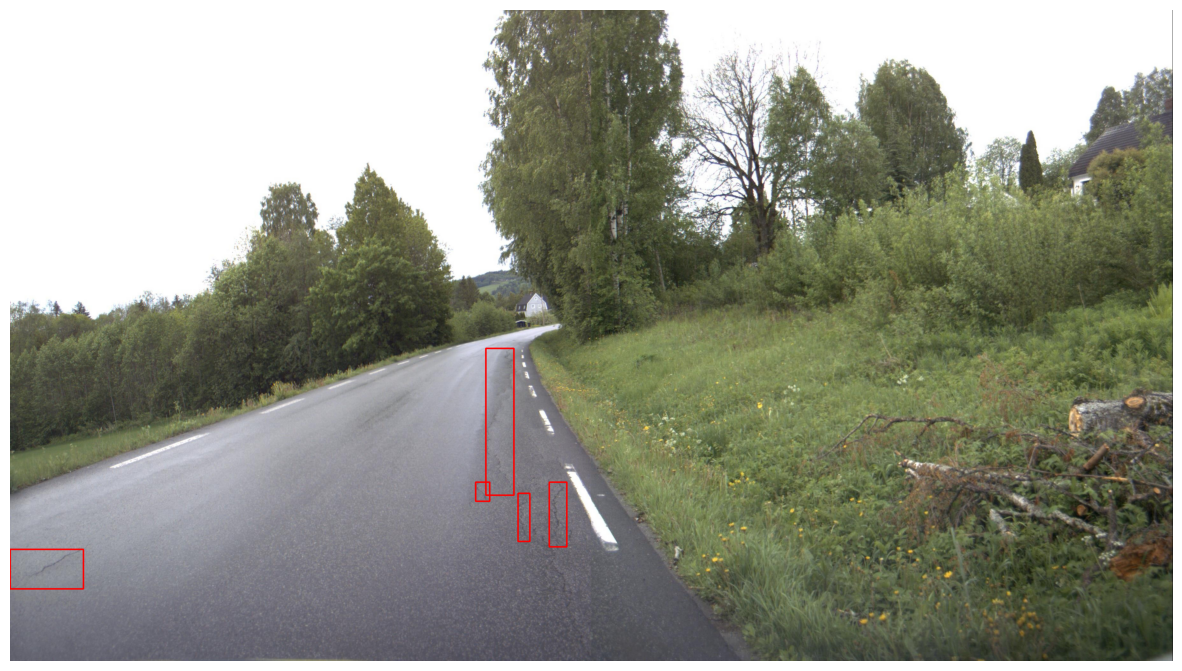

tensor([1, 1, 1, 1, 1])

In [34]:
import cv2

def visualize():
    """
    draw the box. very, slow, avoid using
    """
    images, targets = next(iter(train_data_loader))
    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    for i in range(len(images)):
        if targets[i]['boxes'].shape[0]== 0:   continue
        boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
        sample = images[i].permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(15, 12))
        for box in boxes:
            cv2.rectangle(sample,
                        (box[0], box[1]),
                        (box[2], box[3]),
                        (220, 0, 0), 3)
        ax.set_axis_off()
        plt.imshow(sample)
        plt.show()
        return targets[i]['labels']
visualize()

### Make model

In [ ]:
# Problems with packages.
# yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', autoshape=False, pretrained= True)  # load pretrained


In [3]:
# Model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 5  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # move model to the right device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device) # TODO Change to device when running!!
    return model
#model.to('cpu') # TODO Change to device when running!!
model = get_model()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

### Test forward

In [6]:
def test_forward(device):
    with torch.no_grad():
        images,targets = next(iter(train_data_loader))
        images = [image.to(device) for image in images]
        model.eval()
        return model(images)

#out = test_forward('cuda')
#out



### Train loop

In [6]:
def train(train_dataloader):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        
        optimizer.zero_grad()
        images, targets = data[0], data[1]

        x, y = ([], [])
        for image, target in zip(images, targets):
            if len(target['labels']) > 0:
                x.append(image.to(device))
                y.append({k: v.to(device) for k, v in target.items()}) # [{k: v.to(device) for k, v in t.items()} for t in targets]
        if len(x) <= 0:
            continue
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(x, y)

        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        
        print('hrmf')
        if i > 3:   
            save_model_path = f'saved_models/test_e{epoch}_batch_{i}.pt'
            torch.save(model.state_dict(), save_model_path)
            break
        if i % 25 == 0:
            print(f"Iteration #{i} loss: {loss}")
        if i % 50 == 0 and i > 0:
            save_model_path = os.path.join( '/cluster/home/henrikya/object_detection/saved_models/', f'torch2_e{epoch}_batch_{batch_i}.pt')
            torch.save(model.state_dict(), save_model_path)

    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss


for epoch in range(10):
    start = time.time()
    train_loss = train(train_data_loader)
    print(f"Epoch #{epoch} loss: {train_loss}")   
    end = time.time()
    print(f"Took {(end - start) / 60} minutes for epoch {epoch}")

hrmf
Iteration #0 loss: 3.0141873359680176
hrmf
hrmf
hrmf
hrmf
Epoch #0 loss: 0.0009102830748542462
Took 0.1663173238436381 minutes for epoch 0
hrmf
hrmf
Epoch #1 loss: 0.0005493389235602485
Took 0.05033177534739176 minutes for epoch 1
hrmf
Iteration #0 loss: 0.9804986119270325
hrmf
hrmf
hrmf
hrmf
Epoch #2 loss: 0.0005119948800093208
Took 0.05272010564804077 minutes for epoch 2
hrmf
hrmf
hrmf
Epoch #3 loss: 0.0007098696371114332
Took 0.051195041338602705 minutes for epoch 3
hrmf
Iteration #0 loss: 0.43353134393692017
hrmf
hrmf
hrmf
Epoch #4 loss: 0.0002860746157714744
Took 0.05296331246693929 minutes for epoch 4
hrmf
hrmf
hrmf
Epoch #5 loss: 0.0003333251558098139
Took 0.05010135968526205 minutes for epoch 5
hrmf
Iteration #0 loss: 0.39681416749954224
hrmf
hrmf
hrmf
hrmf
Epoch #6 loss: 0.0008051955427219665
Took 0.052753694852193195 minutes for epoch 6
hrmf
Iteration #0 loss: 0.26853248476982117
hrmf
hrmf
hrmf
Epoch #7 loss: 0.0002962359854208878
Took 0.05337060689926147 minutes for epo

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [ ]:
batch_i = 0

model.train()
model.to(device)
start =time.time()
for epoch in range(10):
    print(f'[Epoch: {epoch}]:')

    for images, targets in train_data_loader:
        print(batch_i, type(images), type(targets))
        
        x, y = ([], [])
        for image, target in zip(images, targets):
            if len(target['labels']) > 0:
                x.append(image.to(device))
                y.append({k: v.to(device) for k, v in target.items()}) # [{k: v.to(device) for k, v in t.items()} for t in targets]
        if len(x) <= 0:
            continue

            
        loss_dict = model(x, y)
        losses = sum(loss for loss in loss_dict.values())
        # TODO report loss
        print(f'   Losses are: {losses=}')
        losses.backward()
        optimizer.step()
        lr_scheduler.step()
        if time.time() - start > 1800.0:
            break
    
    save_model_path = os.path.join( '/cluster/home/henrikya/object_detection/saved_models/', f'torch_e{epoch}_batch_{batch_i}.pt')
    #torch.save(model.state_dict(), save_model_path)
    if time.time() - start > 1800.0:
            break
    


In [ ]:
epoch
batch_i = 5

In [ ]:

save_model_path = os.path.join( '/cluster/home/henrikya/object_detection/saved_models/', f'torch_e{epoch}_batch_{batch_i}.pt')
torch.save(model.state_dict(), save_model_path)


In [ ]:
train_data[7][1]

### Loading model

Compare these models:  
Saved model to   saved_models/test_e0_batch_100.pt  /not nan, expect that this  

Iteration #175 loss: nan
Iteration #250 loss: nan



Saved model to   saved_models/test_e0_batch_250.pt  

In [7]:
save_model_path = 'saved_models/test1.pt'
model.train()
torch.save(model.state_dict(), save_model_path)

In [8]:
device = 'cuda'
torch.cuda.empty_cache()
model = get_model().to(device)

PATH = 'saved_models/test_e19_batch_3000.pt' # 'saved_models/test.pt'
model.load_state_dict(torch.load(PATH))
test_forward(device)

[{'boxes': tensor([[3.6489e-03, 1.3501e+03, 6.5476e+02, 1.6342e+03],
          [0.0000e+00, 1.6653e+03, 5.1388e+01, 1.7075e+03],
          [8.0626e+02, 1.2637e+03, 8.8065e+02, 1.3049e+03],
          [1.7740e+03, 4.2078e+00, 2.3660e+03, 5.9344e+02],
          [6.4548e+02, 1.2580e+03, 8.9794e+02, 1.3561e+03],
          [2.0511e+03, 0.0000e+00, 2.3863e+03, 3.1073e+02],
          [2.2485e+01, 1.3647e+03, 6.5217e+02, 1.4811e+03],
          [2.6308e+03, 7.4800e+02, 3.3957e+03, 9.4810e+02]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0'),
  'scores': tensor([0.9907, 0.8593, 0.4250, 0.2559, 0.2222, 0.1634, 0.1345, 0.0551],
         device='cuda:0')},
 {'boxes': tensor([[ 387.5995, 1297.1045,  831.5692, 1479.3927],
          [ 253.8576,  168.8854, 1568.3346,  497.6878],
          [  39.0452,   62.5715, 1288.3812,  396.5073],
          [ 156.0957, 1270.7122,  853.3472, 1519.6936],
          [   0.0000,   44.7885,  899.5719,  303.7591],
          [ 618.2795,  273.

In [14]:
device = 'cuda'
model = get_model().to(device)

PATH = '/cluster/home/henrikya/object_detection/saved_models/torch_e0_batch_0.pt'
model.load_state_dict(torch.load(PATH))
test_forward(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.90 GiB total capacity; 8.15 GiB already allocated; 1.44 GiB free; 8.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Evaluate


mAP@0.50,…, 0.05,…,.95

In [10]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

iou_tresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]


metric = MeanAveragePrecision(iou_thresholds=iou_tresholds)
# metric demo:

#metric.update(list(preds), list(targets))
# metric.compute()

In [49]:
device = 'cuda'
model.to(device) # TODO Change to device when running!!
PATH = '/cluster/home/henrikya/object_detection/saved_models/torch_e1_batch_900.pt'
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [11]:
device = 'cpu'
model.to(device) # TODO Change to device when running!!
model.eval()
evals = []

for images, targets in train_data_loader: # val_data_loader
    x, y = ([], [])
    for image, target in zip(images, targets):
        if len(target['labels']) > 0:
            x.append(image.to(device))
            y.append({k: v.to(device) for k, v in target.items()}) # [{k: v.to(device) for k, v in t.items()} for t in targets]
    if len(x) <= 0:
        continue
    with torch.no_grad():
        model_time = time.time()
        preds = model(x)
        print(preds)
        model_time = time.time() - model_time
        
    metric.update(preds, y)
    print(metric(preds, targets))
    #
    evals.append(model_time)

map_dict = metric.compute()
map_dict


[{'boxes': tensor([[ 400.2831, 1299.7327,  754.0106, 1467.5457],
        [1495.5520, 1593.1477, 1601.7601, 1718.0527],
        [1744.8530, 1676.8535, 1959.2692, 2043.9170],
        [  54.0877, 1525.7421,  258.1792, 1622.4613],
        [ 828.0150, 1207.3884,  980.2551, 1274.8195],
        [1052.2948, 1452.9642, 1092.4397, 1510.9784],
        [1407.3645, 1375.1227, 1434.1627, 1413.4872],
        [1414.3837, 1199.4249, 1526.9065, 1428.3867],
        [ 700.3921, 1308.1537,  736.3176, 1345.9070],
        [ 575.1959,  255.5636, 1598.4208,  476.9371],
        [ 920.7723, 1202.4353, 1229.3119, 1222.6108],
        [1753.4293, 1688.1411, 2044.8234, 2035.7263],
        [1403.9119, 1369.8733, 1448.3599, 1420.3544],
        [1681.4310, 1514.8300, 1732.8386, 1592.3387],
        [ 817.1309, 1192.5409, 1240.2180, 1244.4789],
        [ 560.2204,  250.0181, 1615.9142,  475.9660],
        [ 108.1983, 1527.5825,  259.6694, 1592.5638],
        [1486.8234, 1588.9391, 1532.7863, 1633.7697],
        [1541.545

{'map': tensor(0.2937),
 'map_50': tensor(0.5710),
 'map_75': tensor(0.2584),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.2041),
 'map_large': tensor(0.6854),
 'mar_1': tensor(0.0635),
 'mar_10': tensor(0.4048),
 'mar_100': tensor(0.4048),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.2037),
 'mar_large': tensor(0.7778),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [44]:
def evaluate():
    device = 'cpu'
    model.to(device) # TODO Change to device when running!!
    model.eval()
    evals = []

    for images, targets in train_data_loader: # val_data_loader
        x, y = ([], [])
        for image, target in zip(images, targets):
            if len(target['labels']) > 0:
                x.append(image.to(device))
                y.append({k: v.to(device) for k, v in target.items()}) # [{k: v.to(device) for k, v in t.items()} for t in targets]
        if len(x) <= 0:
            continue
        print(y)
        
        with torch.no_grad():
            model_time = time.time()
            preds = model(x)
            print('len', len(y), len(preds))
            print(preds)
            model_time = time.time() - model_time
            
        metric.update(preds, y)
        #
        evals.append(model_time)

    map_dict = metric.compute()
    return map_dict
map_dict = evaluate()
map_dict

[{'boxes': tensor([[1926.1899, 1587.4200, 2032.6000, 1693.8199],
        [   5.7600, 1475.8600,  496.6000, 1707.5500]]), 'labels': tensor([1, 1]), 'image_id': tensor([6181]), 'iscrowd': tensor([0, 0]), 'area': tensor([ 11322.0176, 113722.7500])}]
len 1 1
[{'boxes': tensor([[   0.0000, 1462.8735,  507.2969, 1708.9167],
        [1921.1012, 1588.5452, 2027.3694, 1692.0282],
        [1253.4214, 1088.5002, 1279.5393, 1123.3391],
        [ 815.0197, 1209.0073,  922.7256, 1263.1880],
        [ 233.5651, 1347.1226,  525.0279, 1490.4659],
        [1972.3435, 1576.9240, 2323.8623, 2022.2324],
        [ 825.1385, 1211.3298,  944.4854, 1266.9363],
        [1815.4232, 1429.1633, 2352.1445, 2024.2651],
        [ 769.6295, 1205.0980,  936.1788, 1276.6775],
        [ 212.3631, 1437.1093,  359.9303, 1505.5771],
        [ 944.1755, 1212.5875,  958.7407, 1235.7104],
        [ 842.9371, 1217.0348,  905.8699, 1268.0508],
        [1242.3296, 1085.6959, 1284.5582, 1130.6410]]), 'labels': tensor([1, 1, 1, 3, 

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 346816640 bytes. Error code 12 (Cannot allocate memory)

In [13]:
preds[0]['scores']

tensor([0.3506, 0.3448, 0.3432, 0.3421, 0.3392, 0.3323, 0.3313, 0.3298, 0.3285,
        0.3281, 0.3272, 0.3272, 0.3264, 0.3251, 0.3245, 0.3228, 0.3193, 0.3192,
        0.3179, 0.3179, 0.3178, 0.3173, 0.3172, 0.3171, 0.3132, 0.3128, 0.3126,
        0.3122, 0.3118, 0.3113, 0.3111, 0.3106, 0.3100, 0.3097, 0.3096, 0.3095,
        0.3080, 0.3072, 0.3071, 0.3069, 0.3058, 0.3056, 0.3052, 0.3041, 0.3038,
        0.3032, 0.3031, 0.3030, 0.3027, 0.3025, 0.3019, 0.3015, 0.3014, 0.3014,
        0.3009, 0.2999, 0.2997, 0.2997, 0.2993, 0.2988, 0.2983, 0.2983, 0.2981,
        0.2975, 0.2971, 0.2967, 0.2966, 0.2963, 0.2963, 0.2957, 0.2950, 0.2941,
        0.2937, 0.2933, 0.2928, 0.2926, 0.2920, 0.2912, 0.2911, 0.2908, 0.2907,
        0.2902, 0.2902, 0.2901, 0.2897, 0.2895, 0.2890, 0.2889, 0.2887, 0.2877,
        0.2873, 0.2868, 0.2867, 0.2864, 0.2863, 0.2860, 0.2857, 0.2852, 0.2852,
        0.2838])

In [12]:
y, preds

([{'boxes': tensor([[1798.3400, 1549.4600, 1970.4900, 1684.9800],
           [2464.9600, 1928.5500, 2670.0701, 2034.7700],
           [1465.0300, 1816.8400, 1659.1600, 2027.4500],
           [ 203.2200, 1327.8600,  626.2700, 1386.4700],
           [ 416.2400, 1183.2500,  669.4500, 1333.3199],
           [1410.9900, 1676.8900, 1493.6500, 1718.2300],
           [ 717.4500, 1172.8700,  819.7500, 1188.3300],
           [ 711.2900, 1092.9600,  820.7900, 1179.4399]], device='cuda:0'),
   'labels': tensor([1, 1, 4, 2, 1, 4, 2, 1], device='cuda:0'),
   'image_id': tensor([6387], device='cuda:0')}],
 [{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
   'labels': tensor([], device='cuda:0', dtype=torch.int64),
   'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}])

IndexError: list index out of range

### Submission

In [43]:
# 2 cols

class Submission:
    """
    From chat:
    Norway_000000.jpg, 0 1 2 3 4 5
    
    ImageId: the id of the test image, for example, India_00001
    PredictionString: the prediction string should be space-delimited of 5 integers. For example, 2 240 170 260 240 means
    it's label 2, with a bounding box of coordinates (x_min, y_min, x_max, y_max). We accept up to 5 predictions. 
    For example, if you submit: 
    3 42 24 170 186 1 292 28 430 198 4 168 24 292 190 5 299 238 443 374 2 160 195 294 357 6 1 224 135 356 
    which contains 6 bounding boxes, we will only take the first 5 into consideration.
    """
    
    def __init__(self) -> None:
        self.objectness_treshold = 0.8

        self.n_preds = len(test_data)

        self.submission = pd.DataFrame({'ImageId':['INVALID' for i in range(self.n_preds)], 'PredictionString':['INVALID' for i in range(self.n_preds)]})

        self.submission.index = [i + 8161 for i in range(self.n_preds)]

    def add_batch_preds(self, preds, targets):
        for pred, target in zip(preds, targets):
            idx = target['image_id'].item()
            self.submission.loc[idx, 'ImageId'] = f'Norway_{idx:06d}.jpg'
            # use threshold
            # select only 5 highest above threshold
            mask = pred['scores'].data.numpy() > self.objectness_treshold
            boxes = pred['boxes'].data.numpy()[mask].astype(int)
            labels = pred['labels'].data.numpy()[mask]

            # sanity check
            if len(labels) != boxes.shape[0]:
                print('thats weird!')
                print(boxes, labels, targets, preds)

            a_str = ''
            for i in range(len(labels)):
                a_str += str(labels[i])+ ' ' +' '.join(str(x) for x in boxes[i, :]) + ' ' 
            
            
            self.submission.loc[idx, 'PredictionString'] = a_str
    
    def save_preds():
        self.submission.to_csv('/cluster/home/henrikya/object_detection/predictions/submission.csv')


def fill_submission():
    device = 'cpu'
    model.to(device) # TODO Change to device when running!!
    model.eval()
    evals = []

    submission = Submission()

    for images, targets in test_data_loader: # val_data_loader
        x, y = ([], [])
        for image, target in zip(images, targets):
            if len(target['labels']) > 0:
                x.append(image.to(device))
                y.append({k: v.to(device) for k, v in target.items()}) # [{k: v.to(device) for k, v in t.items()} for t in targets]
        if len(x) <= 0:
            continue
        print(y)
        
        with torch.no_grad():
            model_time = time.time()
            preds = model(x)
            print('len', len(y), len(preds))
            print(preds)
            model_time = time.time() - model_time

            submission.add_batch_preds(preds, targets)
            

        evals.append(model_time)
    print('average model time:', sum(evals)/len(evals))
    submission.save_preds()
    return submission 
submission = evaluate()
map_dict

In [17]:
preds

[{'boxes': tensor([[ 400.2831, 1299.7327,  754.0106, 1467.5457],
          [1495.5520, 1593.1477, 1601.7601, 1718.0527],
          [1744.8530, 1676.8535, 1959.2692, 2043.9170],
          [  54.0877, 1525.7421,  258.1792, 1622.4613],
          [ 828.0150, 1207.3884,  980.2551, 1274.8195],
          [1052.2948, 1452.9642, 1092.4397, 1510.9784],
          [1407.3645, 1375.1227, 1434.1627, 1413.4872],
          [1414.3837, 1199.4249, 1526.9065, 1428.3867],
          [ 700.3921, 1308.1537,  736.3176, 1345.9070],
          [ 575.1959,  255.5636, 1598.4208,  476.9371],
          [ 920.7723, 1202.4353, 1229.3119, 1222.6108],
          [1753.4293, 1688.1411, 2044.8234, 2035.7263],
          [1403.9119, 1369.8733, 1448.3599, 1420.3544],
          [1681.4310, 1514.8300, 1732.8386, 1592.3387],
          [ 817.1309, 1192.5409, 1240.2180, 1244.4789],
          [ 560.2204,  250.0181, 1615.9142,  475.9660],
          [ 108.1983, 1527.5825,  259.6694, 1592.5638],
          [1486.8234, 1588.9391, 1532.7

In [21]:
pred = preds[0]

In [29]:
mask = pred['scores'].data.numpy() > 0.8
boxes = pred['boxes'].data.numpy()[mask].astype(int)
labels = pred['labels'].data.numpy()[mask]

In [42]:
a_str = ''
for i in range(len(labels)):
    a_str += str(labels[i])+ ' ' +' '.join(str(x) for x in boxes[i, :]) + ' ' #

    print(a_str)

1 400 1299 754 1467 
1 400 1299 754 1467 1 1495 1593 1601 1718 
1 400 1299 754 1467 1 1495 1593 1601 1718 1 1744 1676 1959 2043 
1 400 1299 754 1467 1 1495 1593 1601 1718 1 1744 1676 1959 2043 1 54 1525 258 1622 
1 400 1299 754 1467 1 1495 1593 1601 1718 1 1744 1676 1959 2043 1 54 1525 258 1622 1 828 1207 980 1274 
1 400 1299 754 1467 1 1495 1593 1601 1718 1 1744 1676 1959 2043 1 54 1525 258 1622 1 828 1207 980 1274 1 1052 1452 1092 1510 


In [39]:
a_str = str(labels[0])+ ' ' +' '.join(str(x) for x in boxes[0, :]) #
a_str

'1 400 1299 754 1467'

In [38]:
boxes[0, :]

array([ 400, 1299,  754, 1467])

In [25]:
pred['scores'].shape

torch.Size([21])

In [ ]:
submission = Submission()
model.eval()

for images, targets in test_data_loader:

    preds = model(images)
    submission.add_batch_preds(preds, targets)
    break

In [ ]:
pred = preds[0]
pred['labels'], pred['scores']

In [ ]:
test_data[0]

In [ ]:
f"{test_data[0][1]['image_id']}"
idx = test_data[0][1]['image_id']
print(f'Norway_{idx:06d}')

In [ ]:
idx

In [ ]:
os.path.join('Norway' + '_'+ f'{idx:06d}' + '.jpg')

In [ ]:
n_preds = len(test_data)

submission = pd.DataFrame({'ImageId':['INVALID' for i in range(n_preds)], 'PredictionString':['INVALID' for i in range(n_preds)]})

submission.index = [i + 8161 for i in range(n_preds)]
submission

### Memory usage

In [55]:
#np.zeros((10000, 10000))
import psutil

#svmem(total=16717422592, available=5376126976, percent=67.8, used=10359984128, free=1831890944, active=7191916544, inactive=2325667840, buffers=525037568, cached=4000509952, shared=626225152)
#arr = np.zeros((5000, 1000))
psutil.virtual_memory().percent

89.5

In [58]:
psutil.virtual_memory().used * 1e-9 

84.99249152

### Temp experimentation

In [ ]:
t

In [ ]:
metric

In [ ]:
preds, targets

In [ ]:
metric.compute()

In [ ]:
list(targets)

In [ ]:
list(preds[0].keys()), list(targets[0].keys())

In [ ]:
preds[0]['scores']

In [ ]:
loss_dict

In [ ]:
preds[0]['scores']

In [ ]:
metric.compute()

In [ ]:
preds[0]['scores']

In [ ]:
box_img = torchvision.utils.draw_bounding_boxes(torchvision.transforms.functional.pil_to_tensor(images[0]), preds[0]['boxes'], preds[0]['labels'])
box_img

In [ ]:
box_img = torchvision.utils.draw_bounding_boxes( images[0].to(torch.uint8),targets[1]['boxes'], targets[1]['labels'])
box_img

In [ ]:
targets[1]['boxes'].dtype, targets[1]['labels'].dtype

In [ ]:
targets[1]['labels'][0]

In [ ]:
images[0].to(torch.uint8)

In [ ]:
road_dataset.get_pil(torch.tensor(targets[0]['image_id'].item()).dtype

In [ ]:
torch.tensor(images[0], dtype=torch.uint8)

In [ ]:
type(images[0]), type(preds[0]['boxes']), type(preds[0]['labels'])

In [ ]:
targets